# Business Case #5 - Retail - Pre_processing

## Authors:
#### Débora Santos (m20200748),Pedro Henrique Medeiros (m20200742), Rebeca Pinheiro (m20201096)

#### Group D - D4B Consulting

In [1]:
#IMPORT LIBRARIES
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift, DBSCAN, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder, RobustScaler
from itertools import product
from math import ceil
from scipy.cluster.hierarchy import dendrogram
%matplotlib inline
from pandas_profiling import ProfileReport 
%config InlineBackend.figure_format = 'retina' 
from scipy.stats import iqr as IQR
from collections import Counter

from sklearn.base import clone
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
import phik
import matplotlib.cm as cm
from sklearn.manifold import TSNE

#outliers detection
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier

from os.path import join


from sklearn.metrics import pairwise_distances

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Seeting seaborn style
sns.set()

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Collect initial data

In [3]:
#import dataset in csv
df = pd.read_csv('NOVAIMS_MAA_2020e21_BusinessCasesDataScience_MindOverData_RetailChallenge.csv')

### Describe, explore and assess data quality

In [4]:
# First look at the dataframe
df.head()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Measures,Value
0,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,Sell-out units,2.0
1,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,Sell-out values,1540.0
2,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,Sell-out units,4.0
3,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,Sell-out values,3080.0
4,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,Sell-out units,2.0


In [5]:
# First look at the dataframe
df.tail()

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Measures,Value
182342299,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-29,Sell-out units,1.0
182342300,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-20,Sell-out values,638.0
182342301,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-25,Sell-out values,652.0
182342302,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-28,Sell-out values,643.0
182342303,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-29,Sell-out values,638.0


In [6]:
# Data types and null values verification
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182342304 entries, 0 to 182342303
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   ProductFamily_ID    object 
 1   ProductCategory_ID  object 
 2   ProductBrand_ID     object 
 3   ProductName_ID      object 
 4   ProductPackSKU_ID   object 
 5   Point-of-Sale_ID    object 
 6   Date                object 
 7   Measures            object 
 8   Value               float64
dtypes: float64(1), object(8)
memory usage: 12.2+ GB


In [7]:
# Summary statistics for all variables
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ProductFamily_ID,182342304,21,Family_12,38915420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductCategory_ID,182342304,178,Category_178,126256286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductBrand_ID,182342304,1523,ProductBrand_1425,2525774,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductName_ID,182342304,2820,ProductName_2609,1802618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ProductPackSKU_ID,182342304,8509,ProductSKU_3008,975138,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Point-of-Sale_ID,182342304,410,POS_282,975220,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,182342304,1401,2018-12-10,204254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measures,182342304,2,Sell-out units,91171152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Value,1.82342e+08,NaN,NaN,NaN,1760.2,5024.84,-10,1,58,1654,662575


In [8]:
# Replace possible empty values with NaN
df.replace("", np.nan, inplace=True)

# Function to show missing values and their percentages
def missing_data(df):
    l = []
    for col in df.columns:
        missing = df[col].isnull().sum(axis=0)
        percentage = missing/df.shape[0]
        l.append([col,missing,percentage*100])
        df_missing = pd.DataFrame(l, columns = ['Feature','missing','percentage'])
        df_missing = df_missing.sort_values('missing',axis=0, ascending = False)    
    return df_missing

# Check the percentage of missing values
df_missing = missing_data(df)
df_missing = df_missing[df_missing['missing']>0]
df_missing

,Feature,missing,percentage


## Data Preparation:

In [9]:
#Create a copy
df1 = df.copy()

### Feature Engineering

In [10]:
# Change 'Date' data type to datetime
df1['Date'] = df1['Date'].astype('datetime64[ns]')

In [11]:
#Check results
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182342304 entries, 0 to 182342303
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ProductFamily_ID    object        
 1   ProductCategory_ID  object        
 2   ProductBrand_ID     object        
 3   ProductName_ID      object        
 4   ProductPackSKU_ID   object        
 5   Point-of-Sale_ID    object        
 6   Date                datetime64[ns]
 7   Measures            object        
 8   Value               float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 12.2+ GB


In [12]:
#Create a new dataframe filtering only units sold. Rename the column name to quantity
df2 = df1[df1['Measures']== "Sell-out units"]
df2.rename(columns = {'Value':'Quantity'}, inplace = True)
df2

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Measures,Quantity
0,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,Sell-out units,2.0
2,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,Sell-out units,4.0
4,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,Sell-out units,2.0
6,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,Sell-out units,2.0
7,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,Sell-out units,2.0
...,...,...,...,...,...,...,...,...,...
182342291,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-01-28,Sell-out units,1.0
182342296,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-20,Sell-out units,1.0
182342297,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-25,Sell-out units,1.0
182342298,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-28,Sell-out units,1.0


In [13]:
#Create a new dataframe filtering only sales vales and rename the column to Sales values
df3 = df1[df1['Measures']== "Sell-out values"]
df3.rename(columns = {'Value':'Sales Values'}, inplace = True)
df3

,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Measures,Sales Values
1,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,Sell-out values,1540.0
3,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,Sell-out values,3080.0
5,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,Sell-out values,1540.0
9,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,Sell-out values,1620.0
10,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,Sell-out values,1620.0
...,...,...,...,...,...,...,...,...,...
182342295,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-01-28,Sell-out values,643.0
182342300,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-20,Sell-out values,638.0
182342301,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-25,Sell-out values,652.0
182342302,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-28,Sell-out values,643.0


In [14]:
#Drop columns Measures and reset index the both dataframes created
df2.drop(['Measures'], axis=1, inplace=True)
df3.drop(['Measures'], axis=1, inplace=True)
df2.reset_index(inplace=True)
df3.reset_index(inplace=True)

In [15]:
#Create the column sales values in df2
df2['Sales Values'] = df3['Sales Values']
df2

,index,ProductFamily_ID,ProductCategory_ID,ProductBrand_ID,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values
0,0,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0
1,2,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0
2,4,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0
3,6,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0
4,7,Family_16,Category_11,ProductBrand_306,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0
...,...,...,...,...,...,...,...,...,...,...
91171147,182342291,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-01-28,1.0,643.0
91171148,182342296,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-20,1.0,638.0
91171149,182342297,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-25,1.0,652.0
91171150,182342298,Family_4,Category_34,ProductBrand_279,ProductName_577,ProductSKU_1813,POS_410,2016-04-28,1.0,643.0


In [16]:
#Drop column index in df2 and save df2 in df1.Now we have a dataframe that we have quantity and sales values in separated columns. 
df2 = df2.drop(columns=['index'])
df1 = df2.copy()

In [18]:
df1 = df1.drop(['ProductFamily_ID','ProductBrand_ID', 'ProductCategory_ID'], axis=1)

In [19]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91171152 entries, 0 to 91171151
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 4.1+ GB


In [20]:
# Summary statistics 
df1.describe().apply(lambda s: s.apply(lambda x:format(x,'g')))

,Quantity,Sales Values
count,9.11712e+07,9.11712e+07
mean,2.17996,3518.23
std,2.29087,6657.08
min,1,-10
25%,1,860
50%,1,1654
75%,2,3416
max,287,662575


In [21]:
#Remove sales with value less than 0
df1 = df1[df1['Sales Values'] >0]

In [22]:
#Create a new column avg price
df1 ['Avg price'] = df1['Sales Values']/df1['Quantity']

### Dealing with Outliers

### Check the prices

In [23]:
#Create a new datafram to store the overal avg price by product
Avg_prices = pd.DataFrame(df1.groupby('ProductPackSKU_ID').mean()['Avg price'])
Avg_prices.reset_index(inplace=True)
Avg_prices.rename(columns = {'Avg price':'Mean_Avg_price'}, inplace = True)
Avg_prices

,ProductPackSKU_ID,Mean_Avg_price
0,ProductSKU_1,1356.138889
1,ProductSKU_10,603.500000
2,ProductSKU_100,1285.944853
3,ProductSKU_1000,1846.208333
4,ProductSKU_1001,2039.275510
...,...,...
8499,ProductSKU_995,2592.333333
8500,ProductSKU_996,2700.277778
8501,ProductSKU_997,2292.947020
8502,ProductSKU_998,2219.120459


In [24]:
#Merge the column with the overal avg price of each product with df1
data_merge = pd.merge(df1,Avg_prices,on='ProductPackSKU_ID')
data_merge

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price
0,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0,770.0,773.871082
1,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0,770.0,773.871082
2,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0,770.0,773.871082
3,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0,810.0,773.871082
4,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0,810.0,773.871082
...,...,...,...,...,...,...,...,...
91170477,ProductName_1602,ProductSKU_4875,POS_410,2019-08-30,1.0,1050.0,1050.0,1031.538462
91170478,ProductName_1602,ProductSKU_4875,POS_410,2019-07-02,1.0,1050.0,1050.0,1031.538462
91170479,ProductName_1167,ProductSKU_3420,POS_409,2017-03-21,1.0,2495.0,2495.0,2495.000000
91170480,ProductName_1602,ProductSKU_4876,POS_410,2016-08-03,1.0,1275.0,1275.0,1275.000000


In [25]:
#Create a new column perc variation to analyse huge differences on prices
data_merge['Perc_Variation'] = round(((data_merge['Avg price'] - data_merge['Mean_Avg_price'])/data_merge['Avg price'])*100,2)

In [26]:
#Sort by perc variation 
data_merge.sort_values(by = 'Perc_Variation')

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
89056817,ProductName_468,ProductSKU_1513,POS_137,2018-10-30,1.0,1.0,1.0,9670.933388,-966993.34
89133766,ProductName_468,ProductSKU_1515,POS_137,2018-10-30,1.0,1.0,1.0,9664.985908,-966398.59
78732676,ProductName_2155,ProductSKU_6495,POS_353,2018-09-13,1.0,1.0,1.0,8573.895582,-857289.56
89689140,ProductName_1379,ProductSKU_4247,POS_315,2018-10-22,1.0,1.0,1.0,6690.600602,-668960.06
89736054,ProductName_2506,ProductSKU_7754,POS_398,2018-10-08,1.0,1.0,1.0,5704.302358,-570330.24
...,...,...,...,...,...,...,...,...,...
91076664,ProductName_2102,ProductSKU_6353,POS_132,2017-01-03,1.0,7669.0,7669.0,497.729381,93.51
91076665,ProductName_2102,ProductSKU_6353,POS_132,2016-06-02,1.0,7923.0,7923.0,497.729381,93.72
90302173,ProductName_1213,ProductSKU_3500,POS_99,2017-05-23,1.0,9891.0,9891.0,498.187926,94.96
57298201,ProductName_2668,ProductSKU_8223,POS_11,2018-05-27,1.0,92962.0,92962.0,1311.198670,98.59


In [27]:
#Filter sales values less than 10 and perc variation <0 to find outliers. 
(data_merge[(data_merge['Sales Values']<10)&(data_merge['Perc_Variation']<0)]).sort_values(by = 'Perc_Variation')

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
89056817,ProductName_468,ProductSKU_1513,POS_137,2018-10-30,1.0,1.0,1.0,9670.933388,-966993.34
89133766,ProductName_468,ProductSKU_1515,POS_137,2018-10-30,1.0,1.0,1.0,9664.985908,-966398.59
78732676,ProductName_2155,ProductSKU_6495,POS_353,2018-09-13,1.0,1.0,1.0,8573.895582,-857289.56
89689140,ProductName_1379,ProductSKU_4247,POS_315,2018-10-22,1.0,1.0,1.0,6690.600602,-668960.06
89736054,ProductName_2506,ProductSKU_7754,POS_398,2018-10-08,1.0,1.0,1.0,5704.302358,-570330.24
73740909,ProductName_470,ProductSKU_1527,POS_137,2019-06-03,1.0,1.0,1.0,4982.676695,-498167.67
73740929,ProductName_470,ProductSKU_1527,POS_137,2018-10-30,1.0,1.0,1.0,4982.676695,-498167.67
73752702,ProductName_470,ProductSKU_1527,POS_391,2019-03-14,1.0,1.0,1.0,4982.676695,-498167.67
73740922,ProductName_470,ProductSKU_1527,POS_137,2019-05-28,1.0,1.0,1.0,4982.676695,-498167.67
74454685,ProductName_470,ProductSKU_1524,POS_137,2019-09-10,1.0,1.0,1.0,4307.601072,-430660.11


In [28]:
#Remove all rows with sales values less than 10 and perc variation lower than -51%
data_merge = data_merge[~((data_merge['Sales Values']<10)&(data_merge['Perc_Variation']<-51))]

In [29]:
#Check results
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91170143 entries, 0 to 91170481
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 6.8+ GB


In [30]:
#Check observations with perc variation lower -500%
(data_merge[(data_merge['Perc_Variation']<-500)]).sort_values(by = 'Perc_Variation')

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
72560627,ProductName_971,ProductSKU_2954,POS_380,2018-11-13,1.0,10.0,10.0,6861.784763,-68517.85
71333366,ProductName_968,ProductSKU_2950,POS_280,2019-08-09,1.0,10.0,10.0,6470.284577,-64602.85
89741317,ProductName_2506,ProductSKU_7756,POS_404,2019-05-08,1.0,10.0,10.0,3960.611419,-39506.11
70207093,ProductName_1155,ProductSKU_3397,POS_11,2019-02-21,1.0,10.0,10.0,3247.080570,-32370.81
89410485,ProductName_1098,ProductSKU_3287,POS_98,2018-07-11,2.0,36.0,18.0,5838.768635,-32337.60
...,...,...,...,...,...,...,...,...,...
70279582,ProductName_253,ProductSKU_860,POS_226,2016-07-20,2.0,600.0,300.0,1802.323210,-500.77
70279516,ProductName_253,ProductSKU_860,POS_226,2016-08-06,1.0,300.0,300.0,1802.323210,-500.77
70279515,ProductName_253,ProductSKU_860,POS_226,2016-08-04,1.0,300.0,300.0,1802.323210,-500.77
70279514,ProductName_253,ProductSKU_860,POS_226,2016-08-02,1.0,300.0,300.0,1802.323210,-500.77


In [31]:
#Remove all rows with perc variation lower than -500%
data_merge = data_merge[~((data_merge['Perc_Variation']<-500))]

In [32]:
#Check results
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169048 entries, 0 to 91170481
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 6.8+ GB


#### General Check

In [33]:
# Define metric features
metric_features = ['Quantity','Sales Values','Avg price']

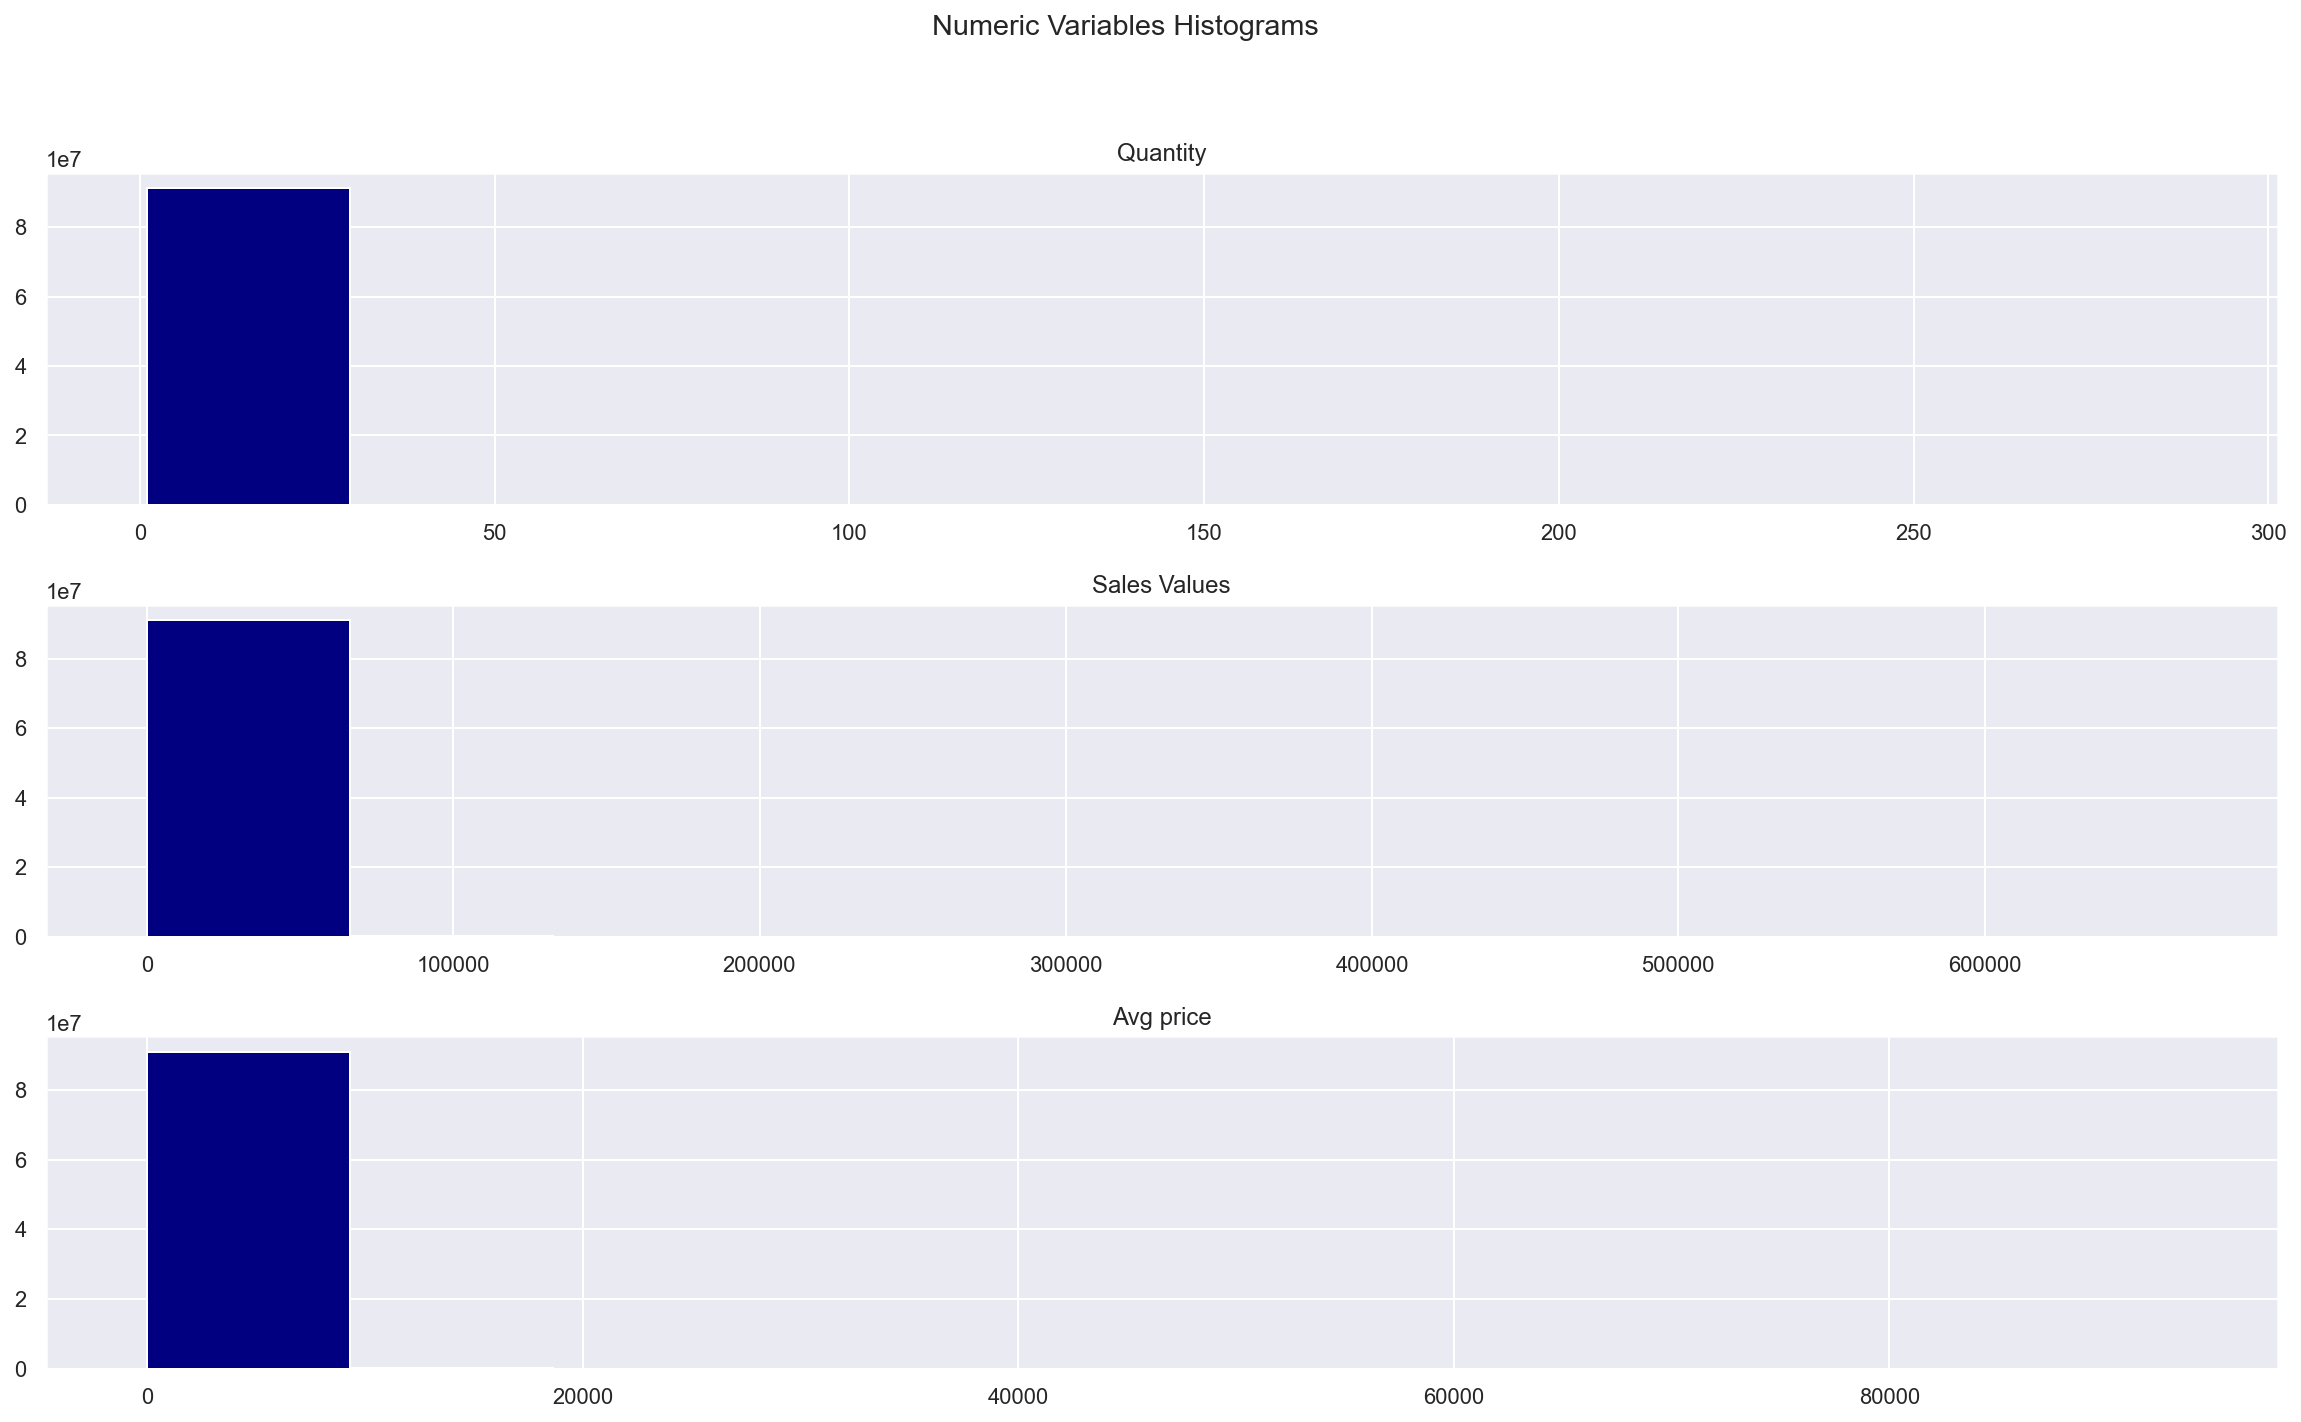

In [34]:
# Histograms for the metric features
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram:
for ax, feat in zip(axes.flatten(), metric_features): 
    ax.hist(data_merge[feat], color = "Navy")
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Histograms"
plt.suptitle(title)
#Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)


#Show Plot
plt.show()

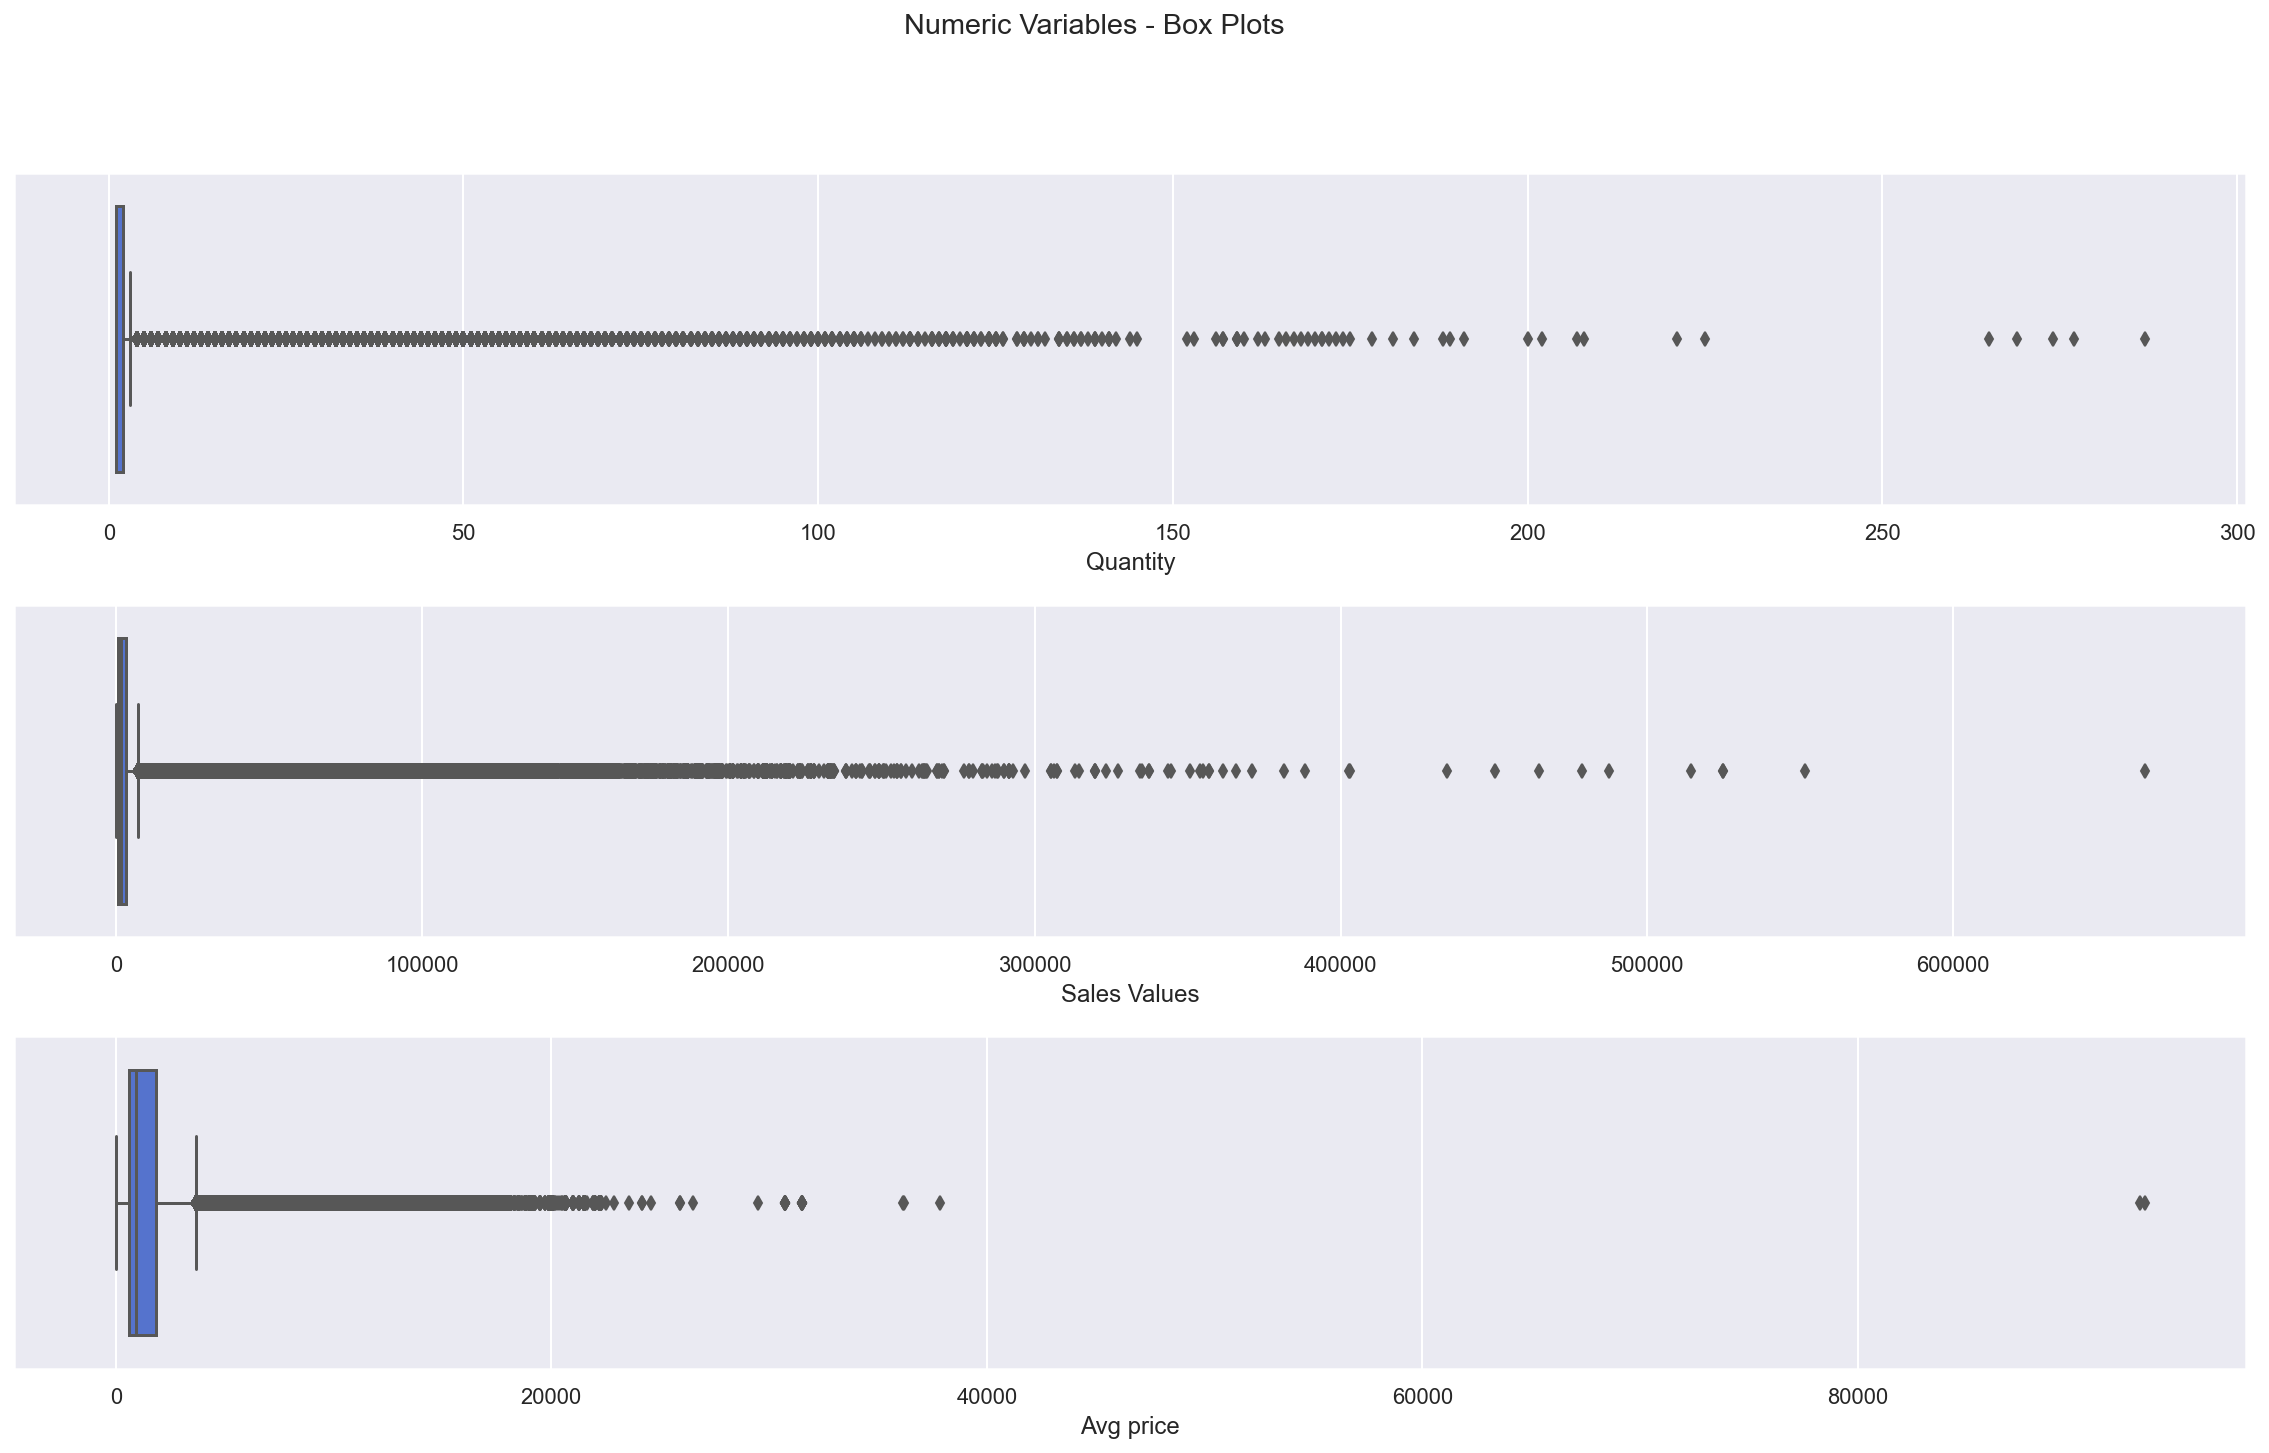

In [35]:
# Boxplots for the metric features
sns.set()

# Prepare figure and create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) /3), figsize=(20, 11))

# Plot the data
# Iterate across axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data_merge[feat], ax=ax,color="royalblue")
    
# Layout
# Add a centered title to the figure
title = "Numeric Variables - Box Plots"

plt.suptitle(title)

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show plots
plt.show()

In [36]:
#Filter observations with price higher than 20000
data_merge[data_merge['Avg price']>20000].sort_values(by = 'Perc_Variation')

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
91144490,ProductName_592,ProductSKU_1843,POS_377,2017-01-31,1.0,22199.0,22199.0,23849.600000,-7.44
91144489,ProductName_592,ProductSKU_1843,POS_377,2017-01-21,1.0,22199.0,22199.0,23849.600000,-7.44
91086655,ProductName_593,ProductSKU_1845,POS_27,2018-09-08,1.0,29490.0,29490.0,31565.086957,-7.04
91145307,ProductName_1317,ProductSKU_4012,POS_108,2016-01-28,1.0,20020.0,20020.0,21260.000000,-6.19
91078520,ProductName_593,ProductSKU_1850,POS_163,2019-05-16,2.0,41220.0,20610.0,21268.831776,-3.20
91078518,ProductName_593,ProductSKU_1850,POS_163,2017-11-30,1.0,20610.0,20610.0,21268.831776,-3.20
91078517,ProductName_593,ProductSKU_1850,POS_163,2017-11-29,1.0,20610.0,20610.0,21268.831776,-3.20
91078519,ProductName_593,ProductSKU_1850,POS_163,2017-09-28,1.0,20610.0,20610.0,21268.831776,-3.20
91086664,ProductName_593,ProductSKU_1845,POS_311,2016-12-20,1.0,30750.0,30750.0,31565.086957,-2.65
91086665,ProductName_593,ProductSKU_1845,POS_311,2016-12-22,1.0,30750.0,30750.0,31565.086957,-2.65


The SKUs 4295, 8223, 3241 and 3242 have transactions with prices very different from the others. We are going to remove these trransactions

In [37]:
#Filter observations with price higher than 20000 and percentage variation higher than 50%
data_merge[((data_merge['Perc_Variation']>50)&(data_merge['Avg price']>20000))]

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
57298201,ProductName_2668,ProductSKU_8223,POS_11,2018-05-27,1.0,92962.0,92962.0,1311.198670,98.59
57359683,ProductName_2668,ProductSKU_8223,POS_282,2017-12-26,1.0,93174.0,93174.0,1311.198670,98.59
69807481,ProductName_1068,ProductSKU_3241,POS_194,2018-03-12,1.0,23575.0,23575.0,5300.088547,77.52
73028634,ProductName_1388,ProductSKU_4295,POS_36,2016-06-30,1.0,36200.0,36200.0,3181.898414,91.21
91099528,ProductName_1069,ProductSKU_3242,POS_140,2019-05-24,1.0,20408.0,20408.0,1458.642857,92.85


In [38]:
#Remove observations with price higher than 20000 and perc variation higher than 50%
data_merge = data_merge[~((data_merge['Perc_Variation']>50)&(data_merge['Avg price']>20000))]

In [39]:
#Check results
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169043 entries, 0 to 91170481
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 6.8+ GB


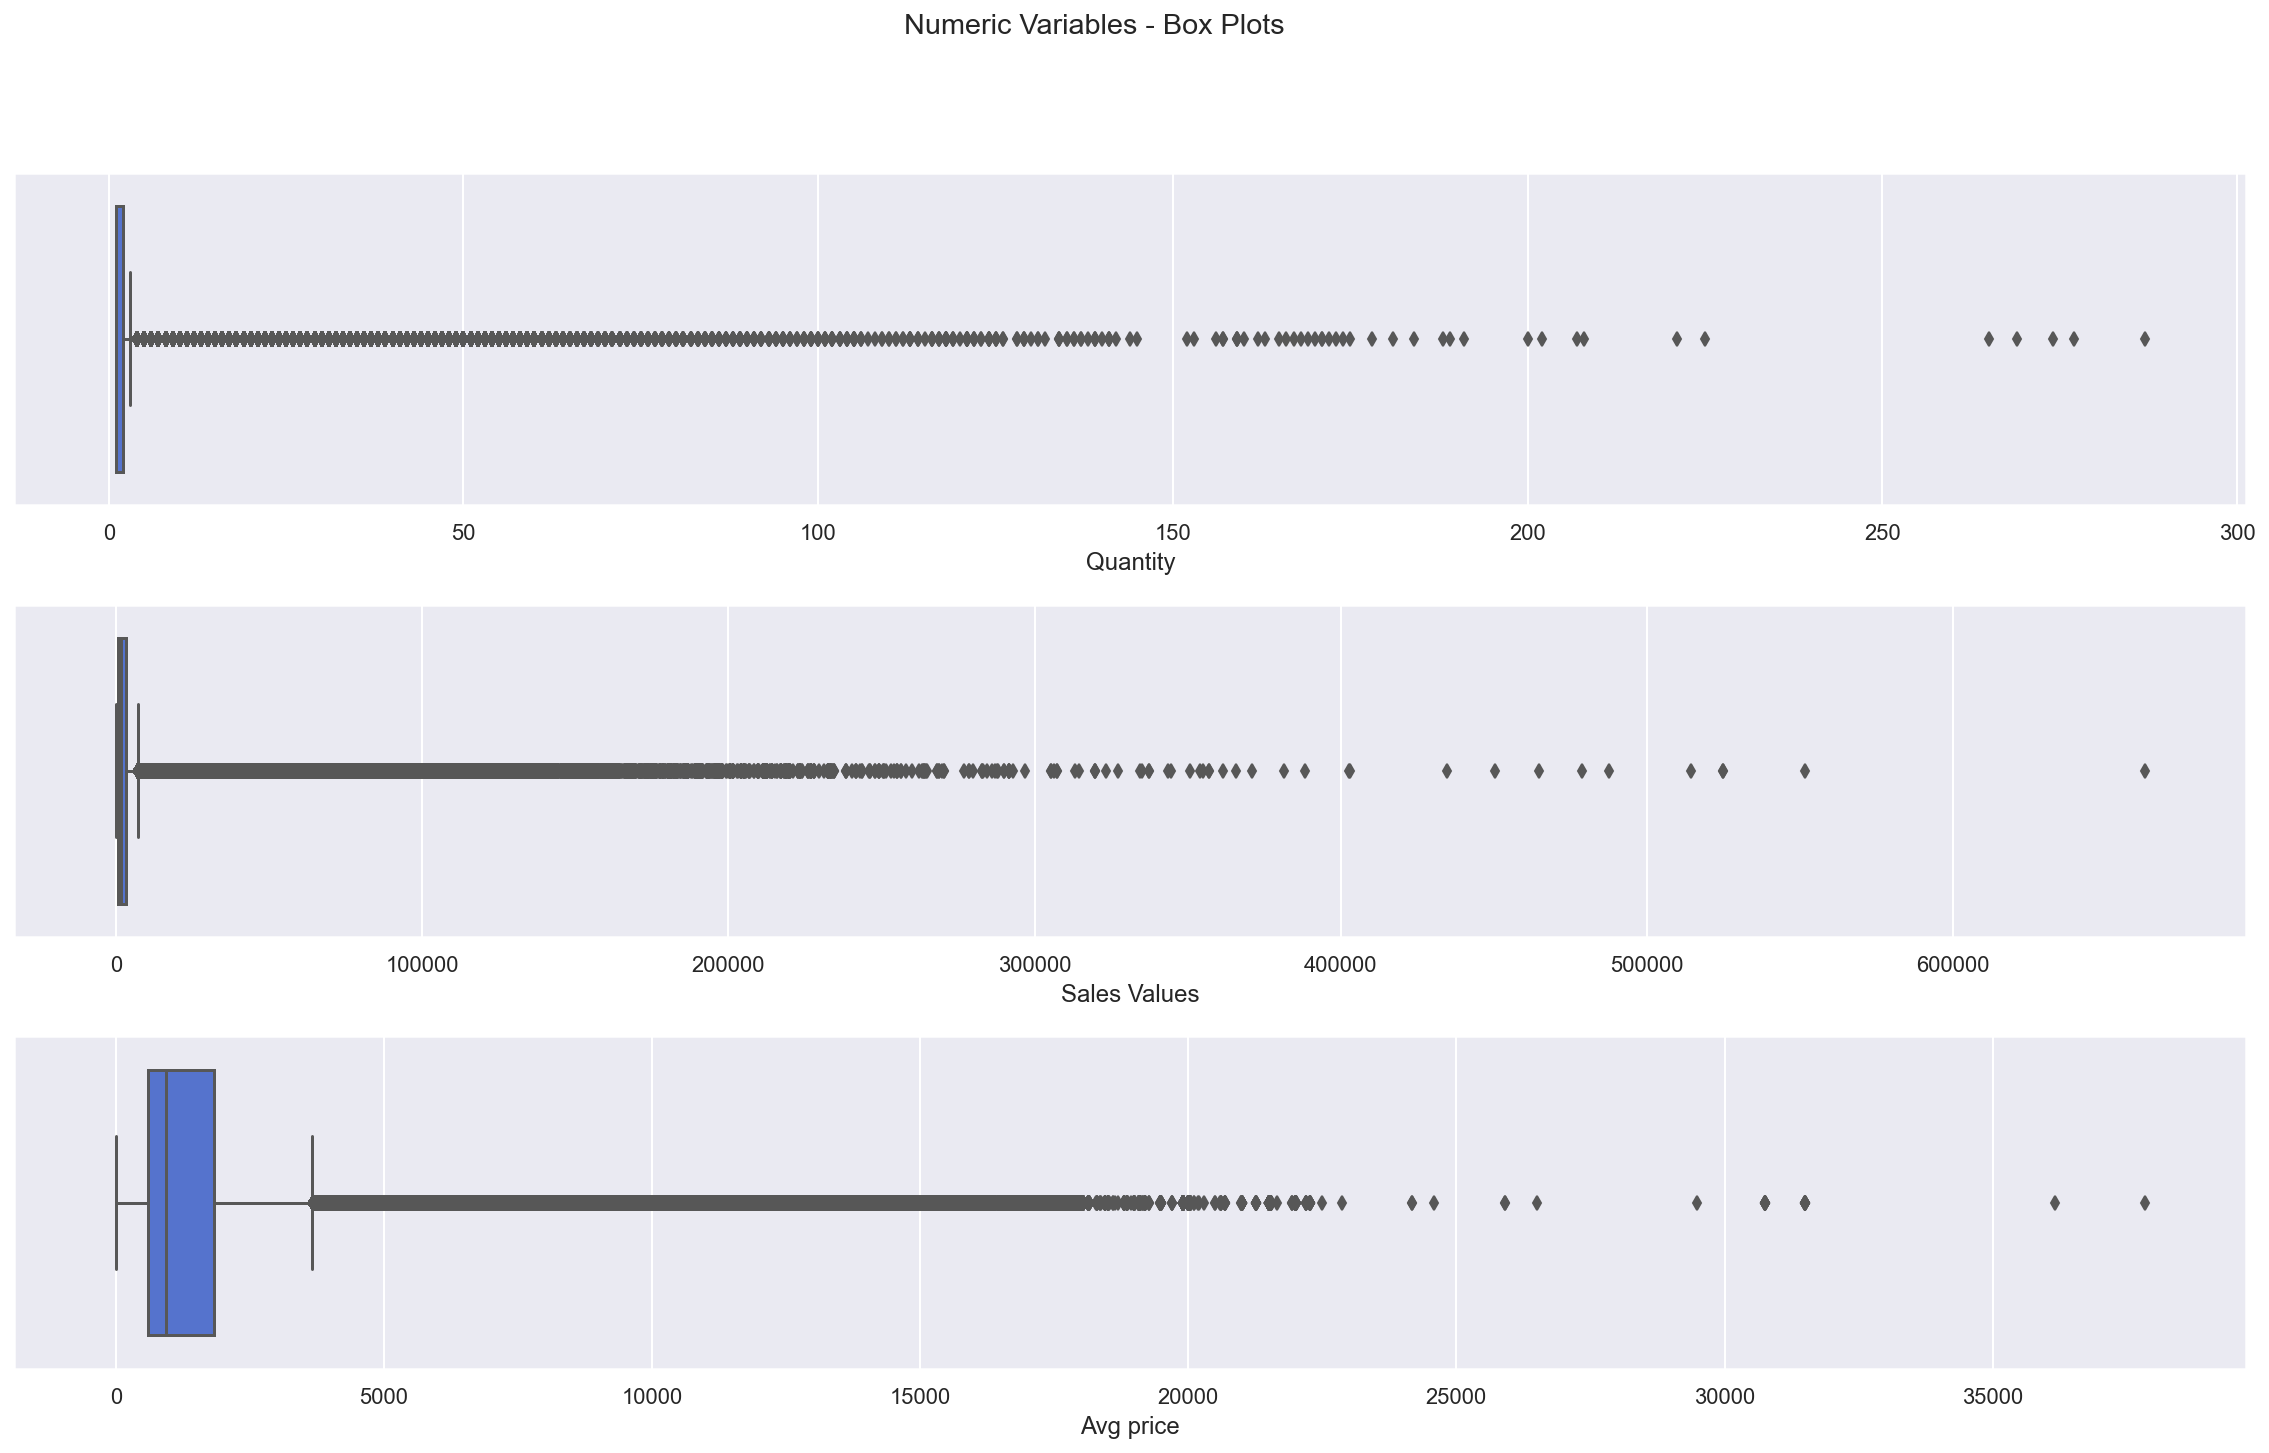

In [40]:
# Boxplots for the metric features
sns.set()

# Prepare figure and create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) /3), figsize=(20, 11))

# Plot the data
# Iterate across axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data_merge[feat], ax=ax,color="royalblue")
    
# Layout
# Add a centered title to the figure
title = "Numeric Variables - Box Plots"

plt.suptitle(title)

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show plots
plt.show()

In [41]:
#Check observations with quatity higher than 150
data_merge[data_merge['Quantity']>150].sort_values(by = 'Perc_Variation')

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
68905340,ProductName_2507,ProductSKU_7764,POS_72,2019-10-04,159.0,68370.000000,430.000000,979.592659,-127.81
1095889,ProductName_993,ProductSKU_3008,POS_146,2017-09-28,169.0,62485.529801,369.736863,755.575290,-104.35
1095481,ProductName_993,ProductSKU_3008,POS_146,2018-01-09,171.0,75458.333333,441.276803,755.575290,-71.22
22416823,ProductName_481,ProductSKU_1572,POS_335,2017-12-26,207.0,87692.906976,423.637232,707.869003,-67.09
80983822,ProductName_1234,ProductSKU_3696,POS_92,2016-01-04,191.0,96081.000000,503.041885,672.714176,-33.73
22100674,ProductName_481,ProductSKU_1572,POS_58,2016-12-29,160.0,88175.000000,551.093750,707.869003,-28.45
22216695,ProductName_481,ProductSKU_1572,POS_161,2018-11-07,188.0,106242.000000,565.117021,707.869003,-25.26
22140892,ProductName_481,ProductSKU_1572,POS_92,2016-01-05,173.0,100164.000000,578.982659,707.869003,-22.26
22125409,ProductName_481,ProductSKU_1572,POS_78,2016-10-06,152.0,88952.000000,585.210526,707.869003,-20.96
22449964,ProductName_481,ProductSKU_1572,POS_362,2016-02-16,159.0,95162.000000,598.503145,707.869003,-18.27


In [42]:
###Excluded all sales that the discount is over 50% and the quantity is higher than 150.
### It looks like a sale with a big discount. We think is not a good observation to cluster analysis and sales forecast. 
data_merge = data_merge[~((data_merge['Perc_Variation']<-50)&(data_merge['Quantity']>150))]

In [43]:
#Check results 
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169039 entries, 0 to 91170481
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 6.8+ GB


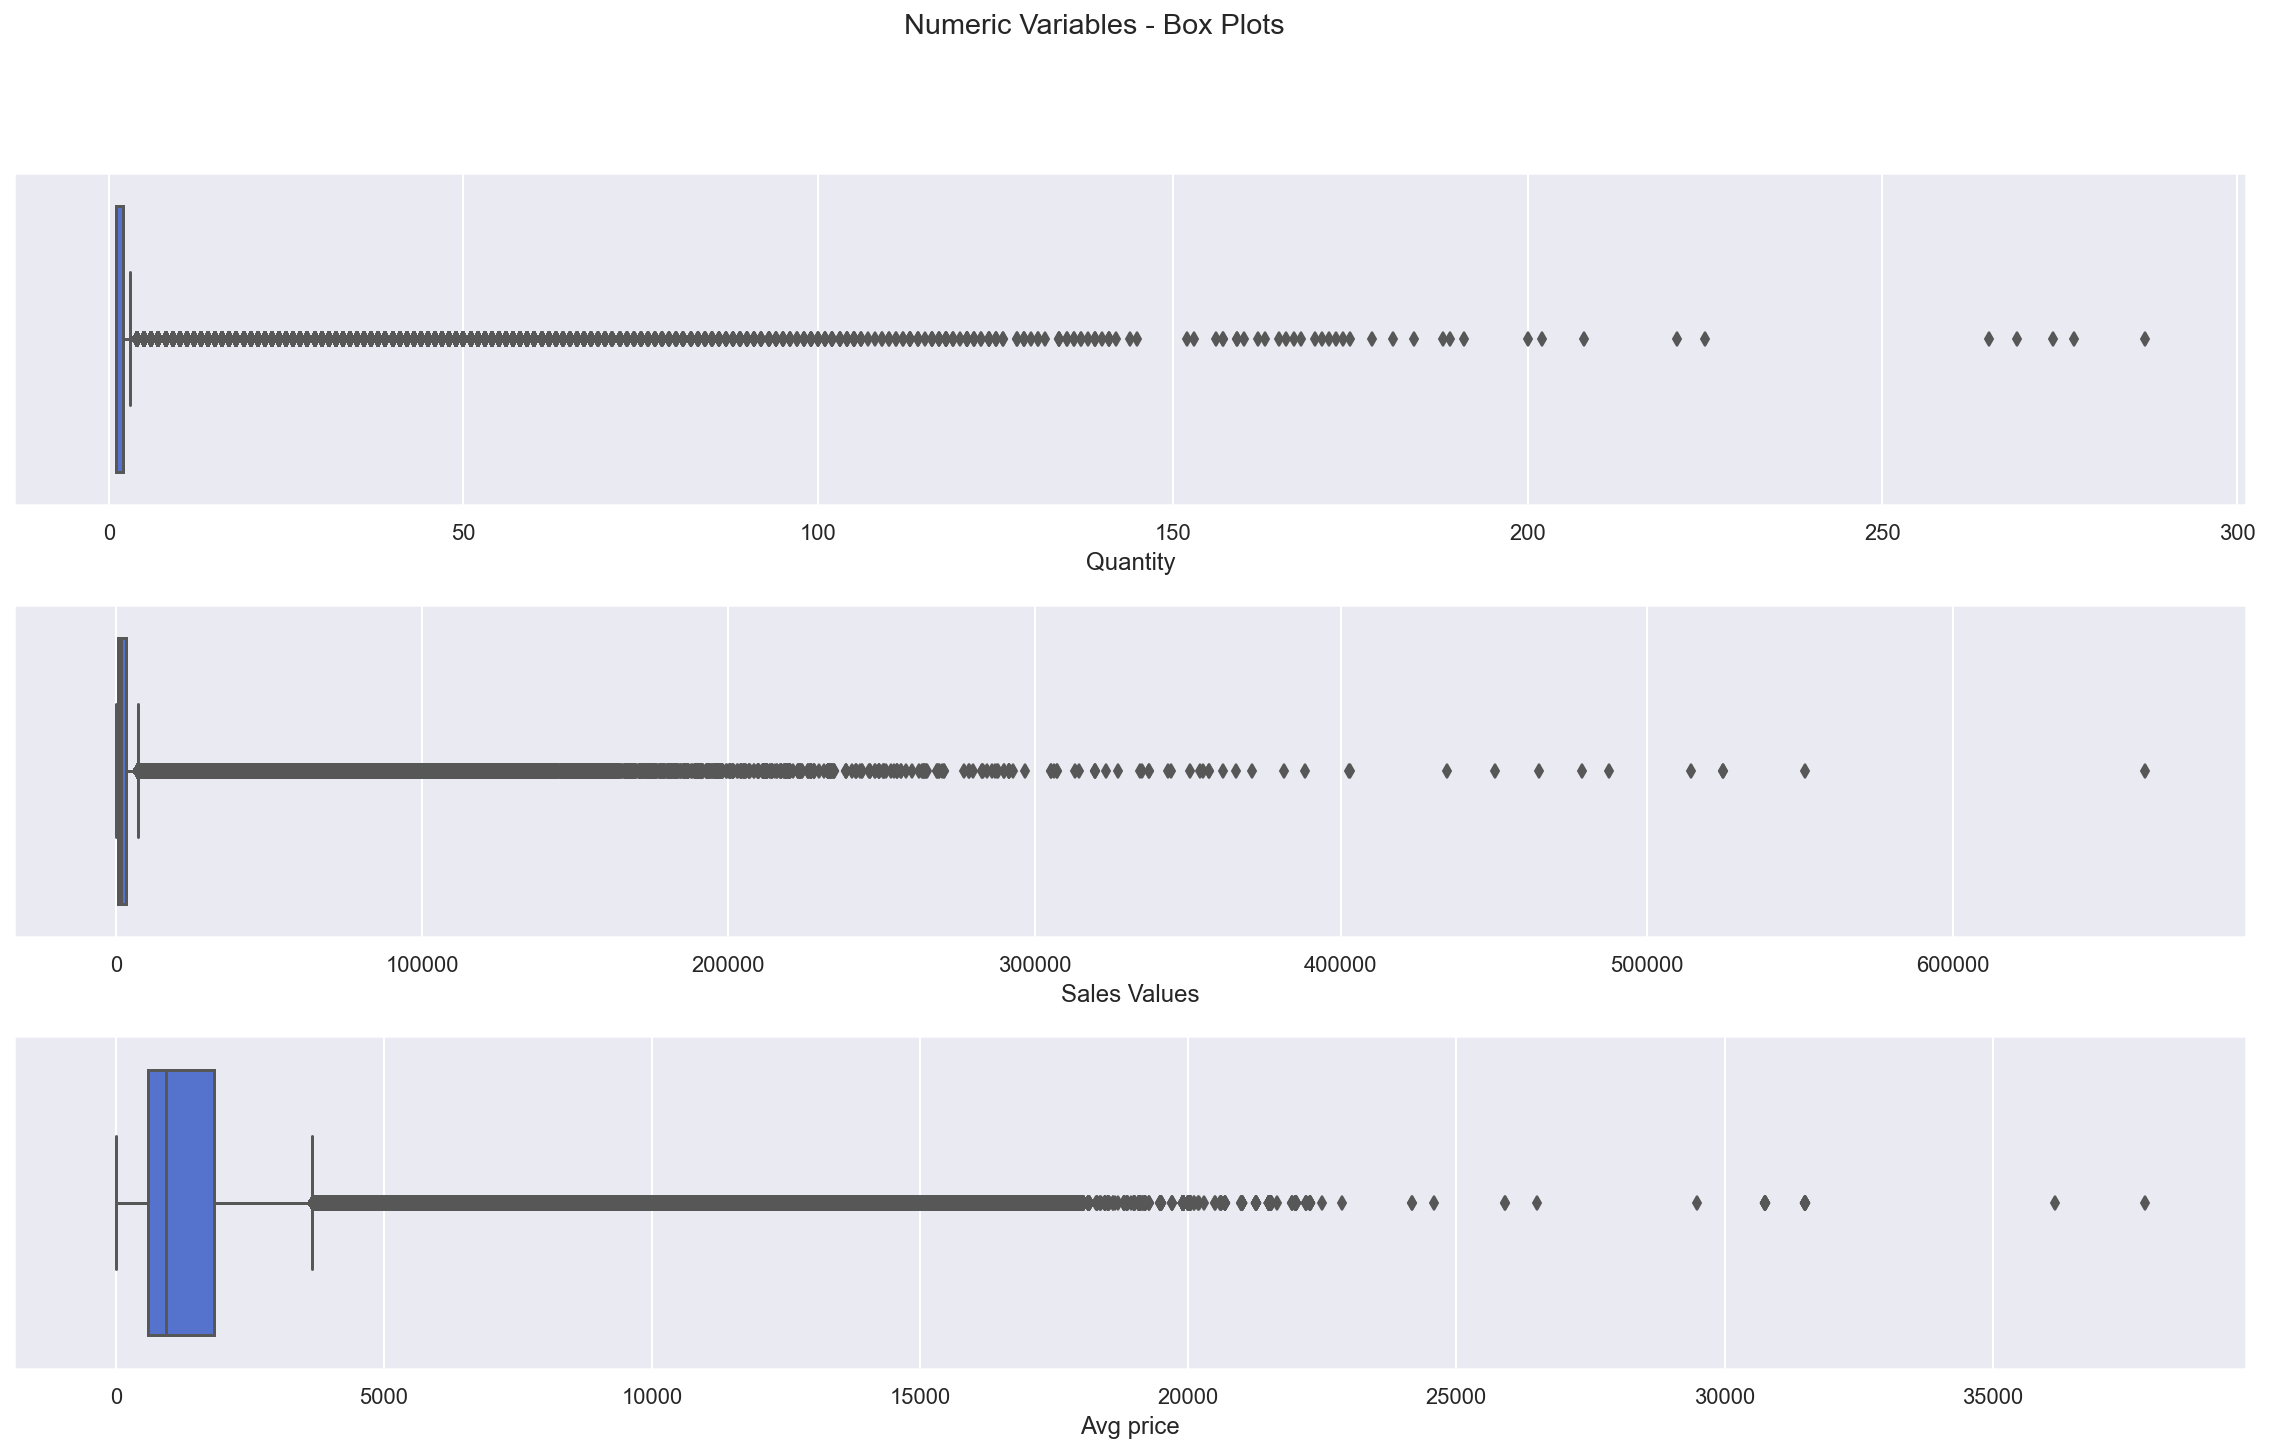

In [44]:
# Boxplots for the metric features
sns.set()

# Prepare figure and create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(len(metric_features) /3), figsize=(20, 11))

# Plot the data
# Iterate across axes objects and associate each box plot
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(data_merge[feat], ax=ax,color="royalblue")
    
# Layout
# Add a centered title to the figure
title = "Numeric Variables - Box Plots"

plt.suptitle(title)

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.3)


plt.show()

In [45]:
#Check sales with sales values 400000. After analysis we don't consider any observation as an outlier
data_merge[data_merge['Sales Values']>400000]

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation
30015676,ProductName_2692,ProductSKU_8264,POS_282,2019-04-23,105.0,478590.0,4558.0,4564.093816,-0.13
48657791,ProductName_2802,ProductSKU_8522,POS_324,2017-02-15,55.0,402985.0,7327.0,7319.280021,0.11
67679609,ProductName_1786,ProductSKU_5402,POS_401,2018-08-27,287.0,524923.0,1829.0,1828.961353,0.00
69754281,ProductName_1068,ProductSKU_3241,POS_22,2018-08-13,85.0,450500.0,5300.0,5300.088547,-0.00
69779822,ProductName_1068,ProductSKU_3241,POS_92,2018-11-05,99.0,524700.0,5300.0,5300.088547,-0.00
69780104,ProductName_1068,ProductSKU_3241,POS_92,2018-04-17,82.0,434600.0,5300.0,5300.088547,-0.00
69780238,ProductName_1068,ProductSKU_3241,POS_92,2018-10-29,92.0,487600.0,5300.0,5300.088547,-0.00
69780247,ProductName_1068,ProductSKU_3241,POS_92,2019-10-08,76.0,402800.0,5300.0,5300.088547,-0.00
71224386,ProductName_297,ProductSKU_1058,POS_91,2018-03-07,225.0,464625.0,2065.0,1943.626752,5.88
77650379,ProductName_1235,ProductSKU_3697,POS_92,2017-11-29,85.0,662575.0,7795.0,6818.765826,12.52


In [46]:
#Save data_merge into df1
df1 = data_merge.copy()

In [47]:
#Check
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169039 entries, 0 to 91170481
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 6.8+ GB


### Recency analysis

#### The cells bellow are transformed in raw nb convert because it takes 7 a 8 hours to run. 

# Upload here the dates related to product and store sales. 
### You Can upload the files generate with these cells on the next 2 cells. 

In [48]:
#import dataset in csv
dfsale_store = pd.read_csv('dfsale_store.csv')

In [49]:
#import dataset in csv
dfsale_prod = pd.read_csv('dfsale_prod.csv')

In [50]:
#Include the new columns first date and last sale in df_new
df_new = pd.merge(df1,dfsale_store,on='Point-of-Sale_ID')

In [51]:
#Include the new columns first date and last sale in df_new
df_new = pd.merge(df_new,dfsale_prod,on='ProductName_ID')

In [52]:
#Check
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169039 entries, 0 to 91169038
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
 9   Firstsale_store    object        
 10  Lastsale_store     object        
 11  Firstsale_product  object        
 12  Lastsale_product   object        
dtypes: datetime64[ns](1), float64(5), object(7)
memory usage: 9.5+ GB


In [53]:
# Change  data type to datetime
df_new['Firstsale_store'] = df_new['Firstsale_store'].astype('datetime64[ns]')

In [54]:
# Change data type to datetime
df_new['Lastsale_store'] = df_new['Lastsale_store'].astype('datetime64[ns]')

In [55]:
# Change data type to datetime
df_new['Firstsale_product'] = df_new['Firstsale_product'].astype('datetime64[ns]')

In [56]:
# Change data type to datetime
df_new['Lastsale_product'] = df_new['Lastsale_product'].astype('datetime64[ns]')

In [57]:
#Check
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91169039 entries, 0 to 91169038
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
 9   Firstsale_store    datetime64[ns]
 10  Lastsale_store     datetime64[ns]
 11  Firstsale_product  datetime64[ns]
 12  Lastsale_product   datetime64[ns]
dtypes: datetime64[ns](5), float64(5), object(3)
memory usage: 9.5+ GB


In [58]:
#CREATE THE VARIABLE: timming difference between last sale of product and last sale from entire database
#Check if the product still selling
df_new['GapLastSale'] = ((max(df_new['Date']) - df_new['Lastsale_product'])).dt.days

In [59]:
#CREATE THE VARIABLE: timming difference between last sale of product and last sale from entire database
#Check if the store still selling
df_new['GapLastSale_Store'] = ((max(df_new['Date']) - df_new['Lastsale_store'])).dt.days

In [60]:
#Create a new variable with the period of sales the stores work in days. Difference btw last sale and first sale. 
df_new['Store_Period']= ((df_new['Lastsale_store'] - df_new['Firstsale_store']).dt.days)

In [61]:
#Filter the products that they don't have sales in more than 180 days. 
df_new[(df_new['GapLastSale']>180)].sort_values(by = 'GapLastSale', ascending=False)

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation,Firstsale_store,Lastsale_store,Firstsale_product,Lastsale_product,GapLastSale,GapLastSale_Store,Store_Period
91169022,ProductName_813,ProductSKU_2445,POS_116,2016-01-05,1.0,435.0,435.0,435.000000,0.00,2016-01-01,2019-11-01,2016-01-05,2016-01-05,1396,0,1400
91168901,ProductName_1928,ProductSKU_5797,POS_372,2016-01-08,1.0,2614.0,2614.0,2614.000000,0.00,2016-01-01,2019-11-01,2016-01-08,2016-01-08,1393,0,1400
91169026,ProductName_448,ProductSKU_1404,POS_153,2016-01-14,1.0,2000.0,2000.0,2000.000000,0.00,2016-01-01,2019-11-01,2016-01-14,2016-01-14,1387,0,1400
91121961,ProductName_1106,ProductSKU_3301,POS_23,2016-01-16,1.0,1855.0,1855.0,1855.000000,0.00,2016-01-01,2019-11-01,2016-01-16,2016-01-16,1385,0,1400
91154719,ProductName_603,ProductSKU_1870,POS_120,2016-01-18,1.0,1081.0,1081.0,1081.000000,0.00,2016-01-01,2019-11-01,2016-01-18,2016-01-18,1383,0,1400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90905579,ProductName_1090,ProductSKU_3275,POS_259,2016-08-08,1.0,2120.0,2120.0,2204.516393,-3.99,2016-01-01,2019-11-01,2016-04-01,2019-05-03,182,0,1400
90905578,ProductName_1090,ProductSKU_3275,POS_259,2017-07-25,2.0,4660.0,2330.0,2204.516393,5.39,2016-01-01,2019-11-01,2016-04-01,2019-05-03,182,0,1400
90905577,ProductName_1090,ProductSKU_3275,POS_240,2018-10-25,1.0,2270.0,2270.0,2204.516393,2.88,2016-01-01,2019-11-01,2016-04-01,2019-05-03,182,0,1400
90905576,ProductName_1090,ProductSKU_3275,POS_240,2019-05-03,1.0,2270.0,2270.0,2204.516393,2.88,2016-01-01,2019-11-01,2016-04-01,2019-05-03,182,0,1400


In [62]:
#Check the number o products that correspond to the filters above
len(df_new[df_new['GapLastSale']>180]['ProductName_ID'].unique())

633

In [63]:
#Remove the products that they don't have sales in the last 180 days. 
df_new = df_new[(df_new['GapLastSale']<180)]

In [64]:
#Check results
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90877776 entries, 0 to 91169031
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
 9   Firstsale_store    datetime64[ns]
 10  Lastsale_store     datetime64[ns]
 11  Firstsale_product  datetime64[ns]
 12  Lastsale_product   datetime64[ns]
 13  GapLastSale        int64         
 14  GapLastSale_Store  int64         
 15  Store_Period       int64         
dtypes: datetime64[ns](5), float64(5), int64(3), object(3)
memory usage: 11.5+ GB


In [65]:
#Remove the stores that they don't have sales in the last 45 days. 
df_new = df_new[df_new['GapLastSale_Store']<45]

In [66]:
#check results
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90748395 entries, 0 to 91169031
Data columns (total 16 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
 6   Avg price          float64       
 7   Mean_Avg_price     float64       
 8   Perc_Variation     float64       
 9   Firstsale_store    datetime64[ns]
 10  Lastsale_store     datetime64[ns]
 11  Firstsale_product  datetime64[ns]
 12  Lastsale_product   datetime64[ns]
 13  GapLastSale        int64         
 14  GapLastSale_Store  int64         
 15  Store_Period       int64         
dtypes: datetime64[ns](5), float64(5), int64(3), object(3)
memory usage: 11.5+ GB


In [67]:
print('Percentage of data kept after removing outliers:', np.round(df_new.shape[0] / df2.shape[0], 4))

Percentage of data kept after removing outliers: 0.9954


In [68]:
df_new.drop(['Store_Period'],axis = 1, inplace = True, )

In [69]:
df_new.head()

,ProductName_ID,ProductPackSKU_ID,Point-of-Sale_ID,Date,Quantity,Sales Values,Avg price,Mean_Avg_price,Perc_Variation,Firstsale_store,Lastsale_store,Firstsale_product,Lastsale_product,GapLastSale,GapLastSale_Store
0,ProductName_649,ProductSKU_1970,POS_1,2017-03-04,2.0,1540.0,770.0,773.871082,-0.50,2016-01-01,2019-11-01,2016-01-01,2019-11-01,0,0
1,ProductName_649,ProductSKU_1970,POS_1,2016-05-02,4.0,3080.0,770.0,773.871082,-0.50,2016-01-01,2019-11-01,2016-01-01,2019-11-01,0,0
2,ProductName_649,ProductSKU_1970,POS_1,2016-10-24,2.0,1540.0,770.0,773.871082,-0.50,2016-01-01,2019-11-01,2016-01-01,2019-11-01,0,0
3,ProductName_649,ProductSKU_1970,POS_1,2017-10-13,2.0,1620.0,810.0,773.871082,4.46,2016-01-01,2019-11-01,2016-01-01,2019-11-01,0,0
4,ProductName_649,ProductSKU_1970,POS_1,2017-10-14,2.0,1620.0,810.0,773.871082,4.46,2016-01-01,2019-11-01,2016-01-01,2019-11-01,0,0


In [70]:
df_new.drop(['Avg price','Mean_Avg_price','Perc_Variation','Firstsale_store','Lastsale_store', 'Firstsale_product','Lastsale_product','GapLastSale','GapLastSale_Store'],axis = 1, inplace = True)

In [71]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90748395 entries, 0 to 91169031
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   ProductName_ID     object        
 1   ProductPackSKU_ID  object        
 2   Point-of-Sale_ID   object        
 3   Date               datetime64[ns]
 4   Quantity           float64       
 5   Sales Values       float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 4.7+ GB


### Exporting file to predict demand forecast

In [72]:
df_demand = df_new.copy()
df_demand = df_demand[['ProductName_ID','Point-of-Sale_ID','Date','Quantity']]
df_demand

,ProductName_ID,Point-of-Sale_ID,Date,Quantity
0,ProductName_649,POS_1,2017-03-04,2.0
1,ProductName_649,POS_1,2016-05-02,4.0
2,ProductName_649,POS_1,2016-10-24,2.0
3,ProductName_649,POS_1,2017-10-13,2.0
4,ProductName_649,POS_1,2017-10-14,2.0
...,...,...,...,...
91169011,ProductName_2367,POS_82,2019-06-12,1.0
91169028,ProductName_457,POS_158,2018-07-17,1.0
91169029,ProductName_457,POS_158,2018-07-19,1.0
91169030,ProductName_457,POS_158,2019-08-27,1.0


In [73]:
df_demand.to_csv(os.path.join("df_demand.csv"), index=False)

### Exporting file with final data of preprocessed part.

In [97]:
df_new.to_csv(os.path.join("df_processed.csv"), index=False)